In [1]:
from olfactorybulb.database import *
import os,sys
from neuronunit.tests.olfactory_bulb.publications import *
from neuronunit.tests.olfactory_bulb.tests import *
from neuronunit.models.neuron_cell import NeuronCellModel
from sciunit.suites import TestSuite
from pandas import DataFrame
import quantities as pq
from neuronunit.tests.olfactory_bulb.utilities import cache
from linetimer import CodeTimer
import string, math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import smt
from smt.surrogate_models.genn import GENN, load_smt_data
from scipy import optimize
import linetimer
import multiprocessing
from multiprocessing import Pool, TimeoutError

/home/justas/anaconda2/envs/p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Could not load NEURONBackend


In [2]:
#cache.clear()

In [3]:
cell_type = 'mc'

# Load tests
measurements = Measurement\
    .select(Measurement)\
    .join(Property)\
    .switch(Measurement)\
    .join(Source)\
    .where((Measurement.property.type == "Electrophysiology") & (Measurement.property.id.startswith(cell_type+'_')))\
    .order_by(Measurement.property.id)

properties = {}

for m in measurements:
    test_generic = str(m.property.test_class_generic)
    pub = str(m.source.publication_class).strip()
    class_name = test_generic+pub
    
    if test_generic not in properties:
        properties[test_generic] = []
    
    globals()[class_name] = type(class_name, 
                                 (eval(pub), eval(test_generic)), 
                                 {})
    
    print('creating specific test class: ' + class_name)
    
    test_instance = eval(class_name)(observation={"mean": m.mean * eval(m.property.units), "std": m.std * eval(m.property.units), "n": m.n})
    
    properties[test_generic].append(test_instance)
    
    
# Load model classes
model_classes = list(CellModel\
                    .select(CellModel)\
                    .where(CellModel.cell_type == cell_type.upper())             
                     )
for i, m in enumerate(model_classes):
    nmsp = string.join(m.isolated_model_class.split('.')[:-1],'.')
    cls = m.isolated_model_class.split('.')[-1]

    import_cmd = 'from '+nmsp+' import '+cls+' as Model'+str(i)
    print(import_cmd)
    exec(import_cmd)
    
# Create work item list
work_items = []

for model in model_classes:
    work_items.append({"model_class": model.isolated_model_class })
        
def dowork(item):
    results = item
    results["properties"] = {}
    results["model_score"] = 0
    
    import prev_ob_models
    exec('cell = '+ str(item["model_class"]) +'()')

    model = NeuronCellModel(cell.soma(0.5),name=cell.__class__.__module__+'.'+cell.__class__.__name__)


    for prop in properties.keys():
        
        if prop not in results["properties"]:
            results["properties"][prop] = { "tests": {}, "total_n": 0, "z_score_combined": None}
        
        prop_tests = properties[prop]
        
        for prop_test in prop_tests:
            
            prop_test_result = {}
            results["properties"][prop]["tests"][prop_test.__class__.__name__] = prop_test_result          
            
            try:
                #print('Starting', item, prop_test)
                prediction = prop_test.generate_prediction(model)
                #print('Finished', item, prop_test, prediction)

            except:
                import traceback
                prediction = traceback.format_exc()
                print(prediction)
                
            prop_test_result["observation"] = prop_test.observation
            prop_test_result["prediction"] = prediction
            
            if type(prediction) != str:
                z_score = (prediction - prop_test.observation["mean"])/prop_test.observation["std"]
                z_score = z_score.simplified
            else:
                z_score = 6.0 # errors are treated as 6 std deviation
                
            z_weighed = z_score * prop_test.observation["n"]

            prop_test_result["z_score"] = z_score
            prop_test_result["z_score_weighed"] = z_weighed
            
            results["properties"][prop]["total_n"] += prop_test.observation["n"]
            
        results["properties"][prop]["z_score_combined"] = sum([i["z_score_weighed"] for i in results["properties"][prop]["tests"].values()])
        results["properties"][prop]["z_score_combined"] /= results["properties"][prop]["total_n"]
        
        results["model_score"] += results["properties"][prop]["z_score_combined"].magnitude**2
        
    import math
    results["model_score"] = math.sqrt(results["model_score"])

    return results


creating specific test class: AfterHyperpolarizationAmplitudeTestYu2015
creating specific test class: AfterHyperpolarizationAmplitudeTestBurtonUrban2014
creating specific test class: AfterHyperpolarizationTimeTestYu2015
creating specific test class: AfterHyperpolarizationTimeTestBurtonUrban2014
creating specific test class: SpikeAmplitudeTestYu2015
creating specific test class: SpikeAmplitudeTestBurtonUrban2014
creating specific test class: SpikeHalfWidthTestYu2015
creating specific test class: SpikeHalfWidthTestBurtonUrban2014
creating specific test class: SpikePeakTestYu2015
creating specific test class: SpikeThresholdTestYu2015
creating specific test class: SpikeThresholdTestBurtonUrban2014
creating specific test class: CellCapacitanceTestYu2015
creating specific test class: CellCapacitanceTestBurtonUrban2014
creating specific test class: FISlopeTestBurtonUrban2014
creating specific test class: InputResistanceTestYu2015
creating specific test class: InputResistanceTestBurtonUrban201

In [4]:
params = [    
    { "attr": "cm",        "low": 0.1, "high": 3.0 },
    { "attr": "ena",       "low": 45.0, "high": 50.0 },
    { "attr": "ek",        "low": -90.0, "high": -70.0 },
    { "attr": "gnabar_hh", "low": 0, "high": 1.0 },
    { "attr": "gkbar_hh",  "low": 0, "high": 0.1 },
    { "attr": "gl_hh",     "low": 1.0 / 1000000.0, "high": 100.0 / 1000000.0 },
    { "attr": "el_hh",     "low": -70.0, "high": -50.0 },   
]

In [14]:
def evaluate(ind, raw_scores=False):  
    def do_work():
        from neuron import h, gui

        file = "/home/justas/MC_SWC.hoc"
        h.load_file(file)
        mc = h.MC()
        soma = mc.soma
        all_sec = h.SectionList()
        all_sec = h.allsec()

        for soma in all_sec:
            soma.g_pas = 0

        h.celsius = 6.3
        h.cvode_active(1)

        model = NeuronCellModel(soma(0.5))

        model.name = file + str(ind)

        for pi, pv in enumerate(ind):
            for soma in all_sec:
                setattr(soma, params[pi]["attr"], pv)

        ct = linetimer.CodeTimer(silent=True)

        prop_tests = [
            properties["InputResistanceTest"][1],
            properties["MembraneTimeConstantTest"][1],
            properties["RestingVoltageTest"][1],
            properties["ReboundSpikingTest"][0]
        ]
        
        with ct:
            if raw_scores:
                scores = [test.generate_prediction(model) for test in prop_tests]
                return scores
            else:
                scores = [test.judge(model) for test in prop_tests]

        run_time = ct.took / 1000.0 / 10.0

        scores = np.array([s.score for s in scores])

        return np.sqrt(np.sum(scores**2))+run_time, 
    
    from multiprocess import Pool, TimeoutError
    pool = Pool(processes = 1)
    
    try:
        result = pool.apply_async(do_work).get(timeout=15)
    except TimeoutError:
        print('Simulation timed out')
        pool.terminate()
        result = 9.999,
        
    return result

In [6]:
#eps = np.sqrt(np.finfo(float).eps)

def evaluate_for_opt(individual):
    return evaluate(individual)[0]
    
def grad_evaluate(individual):
    result = optimize.approx_fprime(individual, evaluate_for_opt, np.abs(np.array(individual)*0.0001))
    
    if np.any(np.abs(result)>1e5):
        print('Discarding invalid gradient', result)
        return [None]*len(individual)
    
    return result

In [7]:
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess
    
def get_true_points(n):
    dims = len(params)
    
    if type(n) == int:
        print('getting random points')
        xy = np.random.rand(n, dims)

        for pi, p in enumerate(params):
            lower_bound = p["low"]
            upper_bound = p["high"]

            xy[:,pi] = xy[:,pi]*(upper_bound-lower_bound)+lower_bound
    
    else:
        print('evaluating passed-in points')
        xy = n
    
    processes = 15   
    pool = MyPool(processes = processes, maxtasksperchild=1)    
    z = np.array(pool.map(evaluate_for_opt, xy))
    #grad_z = np.array(pool.map(grad_evaluate, xy))
    grad_z = xy
    pool.terminate()
    pool.join()
    
    valid_z = np.where(z < 10)
    xy = xy[valid_z]
    z = z[valid_z]
    grad_z = grad_z[valid_z]
    
    valid_grad = grad_z[:,0] != np.array(None)
    xy = xy[valid_grad]
    z = z[valid_grad]
    grad_z = grad_z[valid_grad]
    
    
    return xy, z, grad_z

In [8]:
# Training
xt, yt, dyt_dxt = get_true_points(15*len(params))

#px, py, pg = get_true_points(np.array([[ 7.09304053e-01,  4.98941113e+01, -7.00000000e+01,  1.65979225e-01,
#        3.30619495e-02,  3.83766954e-05, -7.00000000e+01]]))

# xt = np.concatenate((xt,px))
# yt = np.concatenate((yt,py))
# dyt_dxt = np.concatenate((dyt_dxt,pg))


print('best initial fitness',np.min(yt))
DataFrame(xt,yt)

getting random points
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
('best initial fitness', 1.7653731127151133)


,0,1,2,3,4,5,6
2.334345,2.669396,45.559674,-77.576867,0.188938,0.059501,0.000084,-56.016752
3.193435,2.560221,46.423060,-83.939099,0.933071,0.053823,0.000043,-69.494046
9.999000,2.909708,48.356094,-80.696849,0.578058,0.018574,0.000068,-53.400635
9.999000,1.213447,48.204216,-80.672867,0.759605,0.032922,0.000052,-56.580645
9.999000,2.344812,49.092435,-72.339695,0.802590,0.095999,0.000039,-54.441936
2.362161,1.323836,49.873449,-71.889445,0.340293,0.082923,0.000095,-65.746523
2.202524,2.765640,46.148240,-80.875502,0.588321,0.041233,0.000095,-57.276723
3.270758,2.040117,47.610349,-89.798611,0.430255,0.064758,0.000042,-68.364894
9.999000,1.692858,48.125717,-74.758447,0.908383,0.049001,0.000087,-58.657157
2.392191,1.129268,48.969129,-72.881758,0.352001,0.042830,0.000032,-67.536343


In [9]:
def plot3d(x,y,z):
    from matplotlib.mlab import griddata

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    zi = griddata(x, y, z, xi, yi, interp='linear')

    #Plot the contour mapping and edit the parameter setting according to your data (http://matplotlib.org/api/pyplot_api.html?highlight=contourf#matplotlib.pyplot.contourf)
    CS = plt.contourf(xi, yi, zi)#, 5, levels=[0,50,100,1000],colors=['b','y','r'],vmax=abs(zi).max(), vmin=-abs(zi).max())
    plt.colorbar()
    plt.show()

In [10]:
def retrain_surrogate():
    try:
        plot3d(xt[:,0],xt[:,1],yt*-1)
    except:
        pass
    
    # GENN
    genn = GENN()
    genn.options["alpha"] = 0.1             # learning rate that controls optimizer step size
    genn.options["beta1"] = 0.9             # tuning parameter to control ADAM optimization
    genn.options["beta2"] = 0.99            # tuning parameter to control ADAM optimization
    genn.options["lambd"] = 0.1             # lambd = 0. = no regularization, lambd > 0 = regularization
    genn.options["gamma"] = 0.0             # gamma = 0. = no grad-enhancement, gamma > 0 = grad-enhancement
    genn.options["deep"] = 2                # number of hidden layers
    genn.options["wide"] = 10                # number of nodes per hidden layer
    genn.options["mini_batch_size"] = 2000    # used to divide data into training batches (use for large data sets)
    genn.options["num_epochs"] = 10         # number of passes through data
    genn.options["num_iterations"] = 50    # number of optimizer iterations per mini-batch
    genn.options["is_print"] = True         # print output (or not)

    load_smt_data(genn, xt, yt, dyt_dxt)    # convenience function to read in data that is in SMT format
    genn.train()                            # API function to train model
    genn.plot_training_history()            # non-API function to plot training history (to check convergence)
    y_pred = genn.predict_values(xt)         # API function to predict values at new (unseen) points
    
    try:
        plot3d(xt[:,0],xt[:,1],yt*-1)
        plot3d(xt[:,0],xt[:,1],y_pred.flatten()*-1)
    except:
        pass
    
    return genn, y_pred

# genn, y_pred = retrain_surrogate()

# plt.plot(yt, y_pred,'o')
# plt.plot([0,100],[0,100],'-')
# plt.xlim((np.min(yt), np.max(yt)))
# plt.ylim((np.min(y_pred), np.max(y_pred)))
# plt.show()

In [11]:
def GA(suggested_pop=None):
    genn.options['print_global'] = False

    from deap import base, creator
    import math

    creator.create("FitnessMin", base.Fitness, weights=(-1,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    import random
    from deap import tools

    def random_indiv():
        result = [random.random()] * len(params)
        for i, pv in enumerate(result):
            result[i] = (params[i]["high"]-params[i]["low"])*pv+params[i]["low"]
        
        return creator.Individual(result)

    toolbox = base.Toolbox()
    toolbox.register("individual", random_indiv)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate_surrogate(individual):
        return genn.predict_values(np.array([individual])).flatten()[0],

    lows = [p["low"] for p in params]
    highs = [p["high"] for p in params]
    
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=0.1, low=lows, up=highs)
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.1, low=lows, up=highs, indpb=0.1)
    toolbox.register("evaluate", evaluate_surrogate)


    n = 50
    toolbox.register("select", tools.selNSGA2, k=int(n*0.2))
    if suggested_pop is None:
        pop = toolbox.population(n=n)
    else:
        pop = [creator.Individual(i) for i in suggested_pop]
        
    CXPB, MUTPB, NGEN = 1, 1, n
    F_DIVERSITY = 0.5

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(NGEN):
        # Select the parents
        elite = toolbox.select(pop)      

        random_offspring = toolbox.population(n=int(n*F_DIVERSITY/2.0))
        diversity_offspring = random_offspring + tools.selRandom(pop, int(n*F_DIVERSITY/2.0))        
        elite_offspring = tools.selRandom(elite, n-len(elite)-len(diversity_offspring))

        offspring = random_offspring + diversity_offspring + elite_offspring

        # Clone the selected individuals
        offspring = map(toolbox.clone, offspring)

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)

        #print(np.min(fitnesses))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the parents + offspring
        pop[:] = elite + offspring
    

    return pop, pop[0], evaluate_surrogate(pop[0])

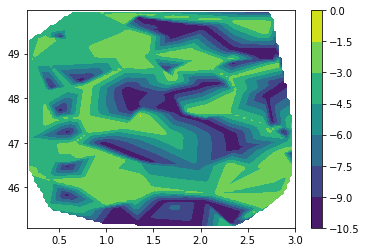

___________________________________________________________________________
   
                                   GENN
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 149
   
___________________________________________________________________________
   
 Training
   
   Training ...
epoch = 0, mini-batch = 0, avg cost =  0.125
epoch = 1, mini-batch = 0, avg cost =  0.028
epoch = 2, mini-batch = 0, avg cost =  0.019
epoch = 3, mini-batch = 0, avg cost =  0.018
epoch = 4, mini-batch = 0, avg cost =  0.017
epoch = 5, mini-batch = 0, avg cost =  0.017
epoch = 6, mini-batch = 0, avg cost =  0.017
epoch = 7, mini-batch = 0, avg cost =  0.016
epoch = 8, mini-batch = 0, avg cost =  0.016
epoch = 9, mini-batch = 0, avg cost =  0.016
   Training - done. Time (sec): 17.2550442


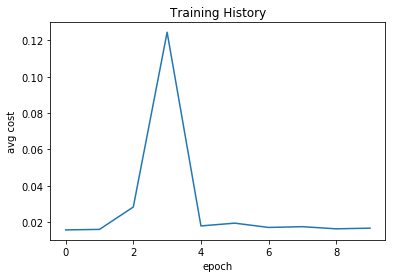

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 149
   
   Predicting ...
   Predicting - done. Time (sec):  0.0017409
   
   Prediction time/pt. (sec) :  0.0000117
   


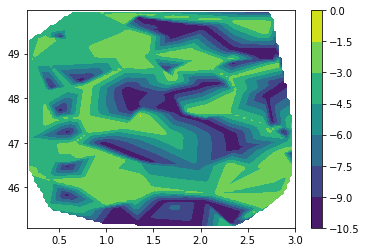

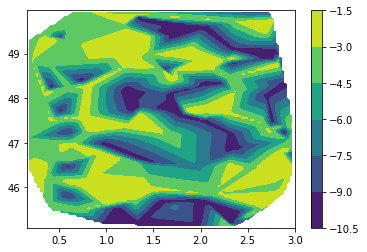

evaluating passed-in points
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
('best fitness so far', 1.3626766475429113)
('cm', 1.3539713120406156)
('ena', 47.6309367801685)
('ek', -79.75833489702077)
('gnabar_hh', 0.488529769220748)
('gkbar_hh', 0.03843905272592299)
('gl_hh', 4.537974850354471e-05)
('el_hh', -62.55493627597634)


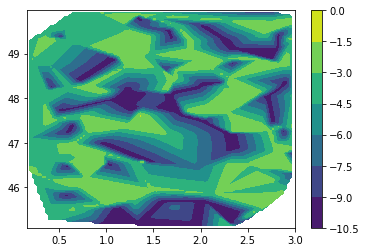

___________________________________________________________________________
   
                                   GENN
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
epoch = 0, mini-batch = 0, avg cost =  0.171
epoch = 1, mini-batch = 0, avg cost =  0.037
epoch = 2, mini-batch = 0, avg cost =  0.024
epoch = 3, mini-batch = 0, avg cost =  0.022
epoch = 4, mini-batch = 0, avg cost =  0.020
epoch = 5, mini-batch = 0, avg cost =  0.020
epoch = 6, mini-batch = 0, avg cost =  0.019
epoch = 7, mini-batch = 0, avg cost =  0.019
epoch = 8, mini-batch = 0, avg cost =  0.018
epoch = 9, mini-batch = 0, avg cost =  0.018
   Training - done. Time (sec): 22.6118591


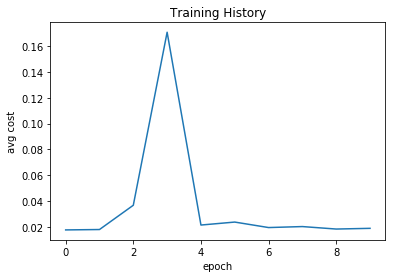

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 200
   
   Predicting ...
   Predicting - done. Time (sec):  0.0016170
   
   Prediction time/pt. (sec) :  0.0000081
   


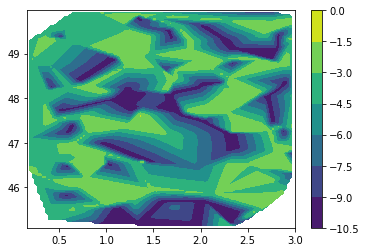

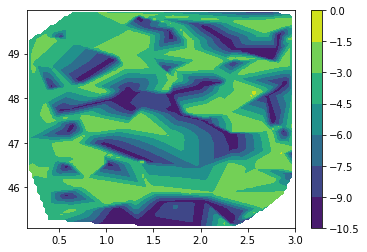

evaluating passed-in points
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
('best fitness so far', 1.3626766475429113)
('cm', 1.3539713120406156)
('ena', 47.6309367801685)
('ek', -79.75833489702077)
('gnabar_hh', 0.488529769220748)
('gkbar_hh', 0.03843905272592299)
('gl

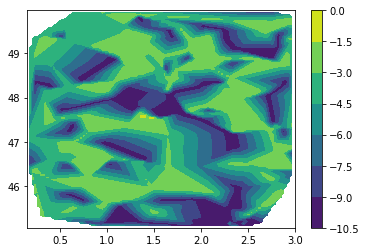

___________________________________________________________________________
   
                                   GENN
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 260
   
___________________________________________________________________________
   
 Training
   
   Training ...
epoch = 0, mini-batch = 0, avg cost =  0.127
epoch = 1, mini-batch = 0, avg cost =  0.033
epoch = 2, mini-batch = 0, avg cost =  0.023
epoch = 3, mini-batch = 0, avg cost =  0.020
epoch = 4, mini-batch = 0, avg cost =  0.018
epoch = 5, mini-batch = 0, avg cost =  0.017
epoch = 6, mini-batch = 0, avg cost =  0.017
epoch = 7, mini-batch = 0, avg cost =  0.016
epoch = 8, mini-batch = 0, avg cost =  0.015
epoch = 9, mini-batch = 0, avg cost =  0.015
   Training - done. Time (sec): 28.3619120


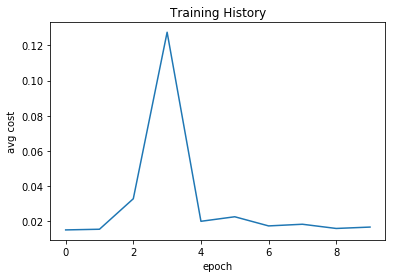

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 260
   
   Predicting ...
   Predicting - done. Time (sec):  0.0024159
   
   Prediction time/pt. (sec) :  0.0000093
   


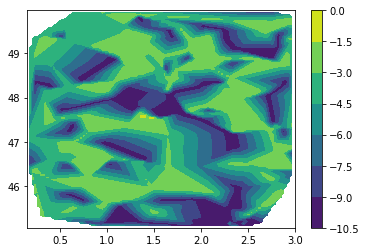

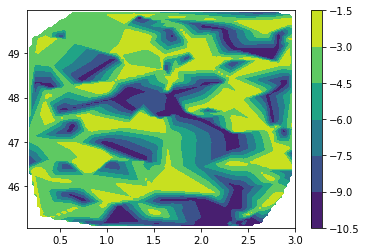

evaluating passed-in points
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
('best fitness so far', 0.9492642410850853)
('cm', 1.107320575057889)
('ena', 47.144564493618645)
('ek', -80.7670296657026)
('gnabar_hh', 0.3673882268304347)
('gkbar_hh', 0.022875301685461966)
('gl_hh', 3.7371434456213035e-05)
('el_hh', -65.32515288074596)


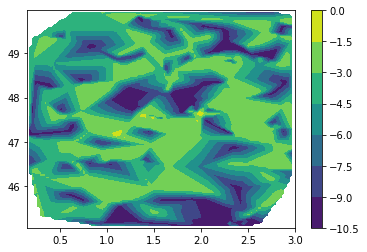

___________________________________________________________________________
   
                                   GENN
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 317
   
___________________________________________________________________________
   
 Training
   
   Training ...
epoch = 0, mini-batch = 0, avg cost =  0.137
epoch = 1, mini-batch = 0, avg cost =  0.033
epoch = 2, mini-batch = 0, avg cost =  0.020
epoch = 3, mini-batch = 0, avg cost =  0.018
epoch = 4, mini-batch = 0, avg cost =  0.017
epoch = 5, mini-batch = 0, avg cost =  0.016
epoch = 6, mini-batch = 0, avg cost =  0.016
epoch = 7, mini-batch = 0, avg cost =  0.015
epoch = 8, mini-batch = 0, avg cost =  0.015
epoch = 9, mini-batch = 0, avg cost =  0.015
   Training - done. Time (sec): 34.0907810


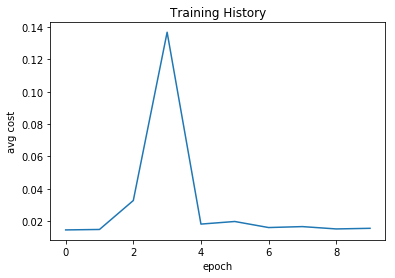

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 317
   
   Predicting ...
   Predicting - done. Time (sec):  0.0019381
   
   Prediction time/pt. (sec) :  0.0000061
   


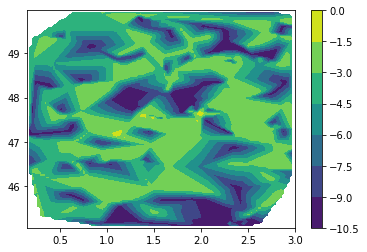

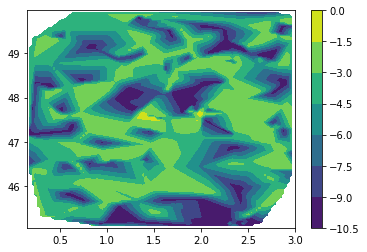

evaluating passed-in points
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
Simulation timed out
('best fitness so far', 0.9492642410850853)
('cm', 1.107320575057889)
('ena', 47.144564493618645)
('ek', -80.7670296657026)
('gnabar_hh', 0.3673882268304347)
('gkbar_hh', 0.022875301685461966)
('gl_hh', 3.7371434456213035e-05)
('el_hh', -65.32515288074596)


In [13]:
for i in range(4):
    genn, y_pred = retrain_surrogate()
    
    pop, pop0, sur_fit = GA(xt)

    # Select indivs 
    ga_pop = np.unique(pop,axis=0)

    new_xt, new_yt, new_grad_yt = get_true_points(ga_pop)
    xt =      np.append(xt,     new_xt,     axis=0)
    yt =      np.append(yt,     new_yt,     axis=0)
    dyt_dxt = np.append(dyt_dxt,new_grad_yt,axis=0)
    new_xt, new_yt, new_grad_yt
    
    best = np.argmin(yt)
    
    print("best fitness so far", yt[best])
    
    for pi, p in enumerate(params):
        print(p["attr"], xt[best][pi])
    
    
    
    



In [15]:
xt[best]

array([ 1.10732058e+00,  4.71445645e+01, -8.07670297e+01,  3.67388227e-01,
        2.28753017e-02,  3.73714345e-05, -6.53251529e+01])

In [16]:
DataFrame(np.column_stack((yt,xt))).sort_values(by=0)

,0,1,2,3,4,5,6,7
266,0.949264,1.107321,47.144564,-80.767030,0.367388,0.022875,0.000037,-65.325153
300,1.266234,2.046904,47.632879,-72.635205,0.578420,0.088539,0.000054,-62.130001
290,1.286266,1.987132,47.632879,-73.434266,0.578420,0.075112,0.000054,-62.130001
297,1.295525,1.987132,47.633609,-73.434266,0.578420,0.075112,0.000054,-62.130001
298,1.296382,1.987132,47.637834,-73.434266,0.578420,0.075112,0.000054,-62.130001
280,1.299694,1.987132,47.573841,-73.434266,0.578420,0.075112,0.000054,-62.012797
294,1.301807,1.987132,47.632879,-73.434266,0.578420,0.075112,0.000054,-62.130001
296,1.301938,1.987132,47.633426,-73.434266,0.578420,0.075112,0.000054,-62.130001
289,1.303920,1.987132,47.632879,-73.434266,0.578420,0.075112,0.000054,-62.130001
286,1.304578,1.987132,47.579079,-73.434266,0.578420,0.075112,0.000054,-62.130001


In [22]:
for pi, p in enumerate(params):
    print(p["attr"], xt[best][pi])

('cm', 1.107320575057889)
('ena', 47.144564493618645)
('ek', -80.7670296657026)
('gnabar_hh', 0.3673882268304347)
('gkbar_hh', 0.022875301685461966)
('gl_hh', 3.7371434456213035e-05)
('el_hh', -65.32515288074596)


In [18]:
ind = xt[np.argmin(yt)]

In [ ]:
ind = [1.0, 45.0, -70.0, 0.033, 0.005, 35.0/1000000.0, -70]

In [88]:
ind

array([ 1.00000000e+00,  4.57764617e+01, -7.50062121e+01,  4.25373548e-01,
        5.91994335e-02,  2.00000000e-05, -4.50000000e+01])

In [74]:
params

[{'attr': 'cm', 'high': 3.0, 'low': 0.1},
 {'attr': 'ena', 'high': 50.0, 'low': 45.0},
 {'attr': 'ek', 'high': -70.0, 'low': -90.0},
 {'attr': 'gnabar_hh', 'high': 1.0, 'low': 0},
 {'attr': 'gkbar_hh', 'high': 0.1, 'low': 0},
 {'attr': 'gl_hh', 'high': 0.0001, 'low': 1e-06},
 {'attr': 'el_hh', 'high': -50.0, 'low': -70.0}]

In [83]:
1e-6 < 2.0e-5

True

In [21]:
evaluate(ind,raw_scores=True)

[array(89.77848949) * megaohm,
 array(23.375) * ms,
 array(-68.60008207) * mV,
 False]

In [80]:
from neuron import h, gui
file = "/home/justas/MC_SWC.hoc"
h.load_file(file)
mc = h.MC()
soma = mc.soma
all_sec = h.SectionList()
all_sec = h.allsec()

h.celsius = 6.3

h.cvode_active(1)

model = NeuronCellModel(soma(0.5))

model.name = file + str(ind)

for pi, pv in enumerate(ind):
    for soma in all_sec:
        setattr(soma, params[pi]["attr"], pv)
        soma.g_pas = 0

scores = [
            properties["InputResistanceTest"][1].generate_prediction(model),
            properties["MembraneTimeConstantTest"][1].generate_prediction(model),
            properties["RestingVoltageTest"][1].generate_prediction(model),
         ]

scores

[array(96.64896965) * megaohm, array(21.625) * ms, array(-68.46683915) * mV]

In [ ]:
GA()

In [ ]:
pop, pop0, sur_fit = GA()

In [ ]:
params

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,Z*-1,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.show()

In [ ]:
raise

In [ ]:
# Run the tests
processes = 15   
from multiprocessing import Pool
pool = Pool(processes = processes, maxtasksperchild=1)
result = pool.map(dowork, work_items)
pool.terminate()
pool.join()
result


In [ ]:
df = []
for m in result:
    row = {}
    
    row['model'] = m["model_class"]
    row['model_score'] = m['model_score']
    
    for prop in m["properties"].keys():
        row[prop] = m["properties"][prop]['z_score_combined']
    
    df.append(row)

DataFrame(df).sort_values(by='model_score').to_csv("mc_property_scores.csv")

In [ ]:
# import pickle
# with open(cell_type + "_validation.json", "r") as f:
#     result = pickle.load(f)
# result

In [ ]:
# import pickle
# with open(cell_type + "_validation.json", "w") as f:
#     pickle.dump(result, f)

In [ ]:
[m for m in result if m['model_class'] == 'prev_ob_models.Chen2002.isolated_cells.MC']

In [ ]:
raise

In [ ]:
cache.clear()
result = dowork(work_items[1])

In [ ]:
result

In [ ]:
from pprint import pprint as pp
for key in result["properties"].keys():
    pp(result["properties"][key])

In [ ]:
result

In [ ]:
prop_test_instance.generate_prediction(model)

In [ ]:
df.to_csv(cell_type+"_model_ephyz_validation_results.csv")

In [ ]:
df_tests = []
row = {"model": "Observations"}
for t, test in enumerate(tests):
    row[test.__class__.__name__ + "_mean"] = test.observation["mean"]
    row[test.__class__.__name__ + "_std"] = test.observation["std"]
    row[test.__class__.__name__ + "_n"] = test.observation["n"]
df_tests.append(row)
        
df_tests = DataFrame(df_tests)
df_tests.to_csv(cell_type+"_model_ephyz_observations.csv")
df_tests

In [ ]:
raise Exception()

In [ ]:
cache.clear()
i = 10 #Max: 10
for item in [work_items[i]]:
    dowork(item)

print("FINISHED")

In [ ]:
raise Exception()

In [ ]:
cache.clear()
import prev_ob_models
cell = prev_ob_models.Saghatelyan2005.isolated_cells.GC()
model = NeuronCellModel(cell.soma(0.5),name=cell.__class__.__module__+'.'+cell.__class__.__name__)
RheobaseTestBurtonUrban2015().generate_prediction(model)

In [ ]:
model = None
cell = None
raise Exception()